# Smoothing parameters and time-lapse inversion
In this notebook, we will see what it the impact of the different smoothing parameters and how we can use them to perform time-lapse inversion.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')
from emagpy import Problem
datadir = '../src/examples/'

## Smoothing parameters
There are three different smoothing parameters:
- `alpha`: linked to the vertical smoothing
- `beta`: linked to lateral smoothing
- `gamma`: linked to smoothing with the first inverted survey (usefull for time-lapse inversion)

Removing 1 NaN from survey


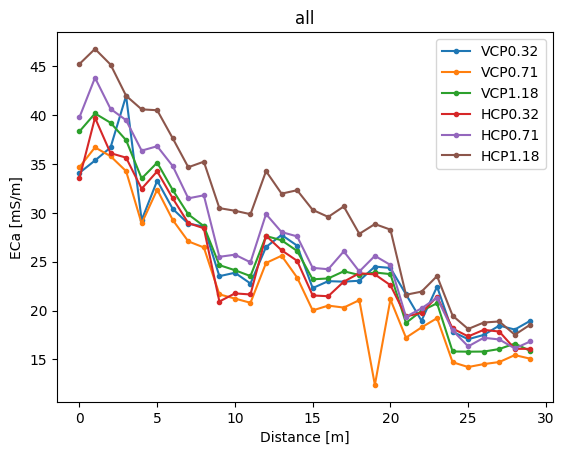

In [2]:
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.surveys[0].df = k.surveys[0].df[:30] # truncate dataset
k.show()

### Vertical smoothing (`alpha`)
The `alpha` parameter regulates the vertical smoothing of the profile. It is needed to regularize the inversion.
It plays an important role in smooth inversion with many layers such as used with `Problem.invertGN()`.
To determine the optimal value of `alpha` a common method is to plot the so-called 'L-curve' that show the size of the model and data misfit as a function of alpha. It can be plotted using the `Problem.lcurve()` method.

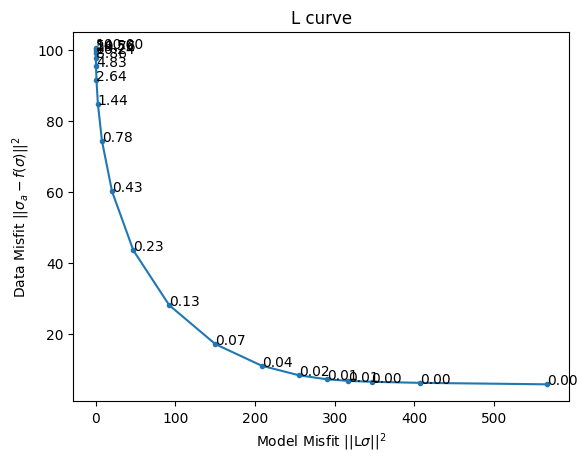

In [3]:
k.lcurve()

From the L-curve, we look for the alpha value that offers the best trade-off between the model and data misfit. This value is usually taken at the maximum curvature point of the curve. In this case it would corresponds to 0.07. This value can then be used in the call to `Problem.invert(alpha=alpha)`.

The graphs below shows the impact of different values of `alpha`. Larger alpha values will give a smoother model, while smaller alpha values can show very high/low EC values.

30/30 inverted

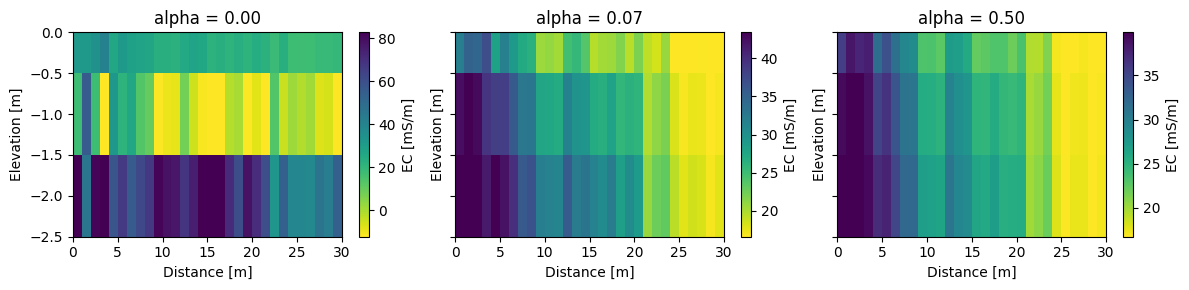

In [4]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))
for i, alpha in enumerate([0, 0.07, 0.5]):
    ax = axs[i]
    k.invert(alpha=alpha)
    k.showResults(ax=ax)
    ax.set_title('alpha = {:.2f}'.format(alpha))

### Lateral smoothing (`beta`)
We can see that the data present some similarity between continguous measurements. To force lateral smoothing we can use the `beta` parameters. It will penalize the objective function with the difference between two continuous profiles. Note that this can be dangerous in some conditions, for instance if the first profile is badly inverted.

The figure below show the effect of lateral smoothing.

30/30 inverted

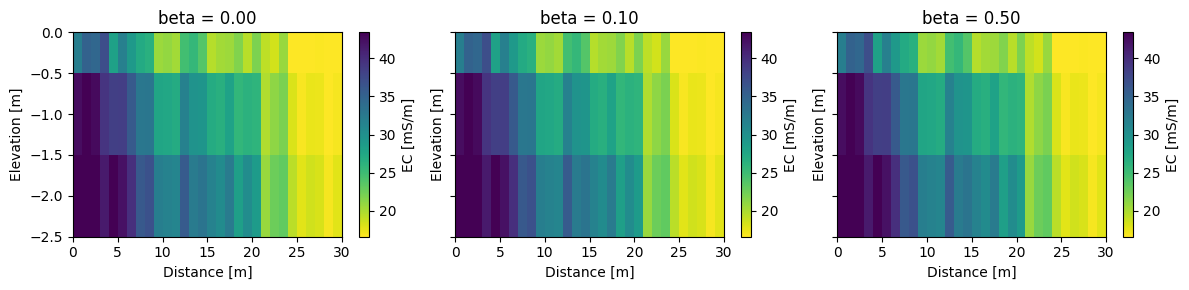

In [5]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))
for i, beta in enumerate([0, 0.1, 0.5]):
    ax = axs[i]
    k.invert(beta=beta)
    k.showResults(ax=ax)
    ax.set_title('beta = {:.2f}'.format(beta))

### Reference survey smoothing (`gamma`) or time-lapse inversion
`gamma` controls the smoothing between the first survey and subsequent survey. This way a quasi time-lapse inversion can be performed.

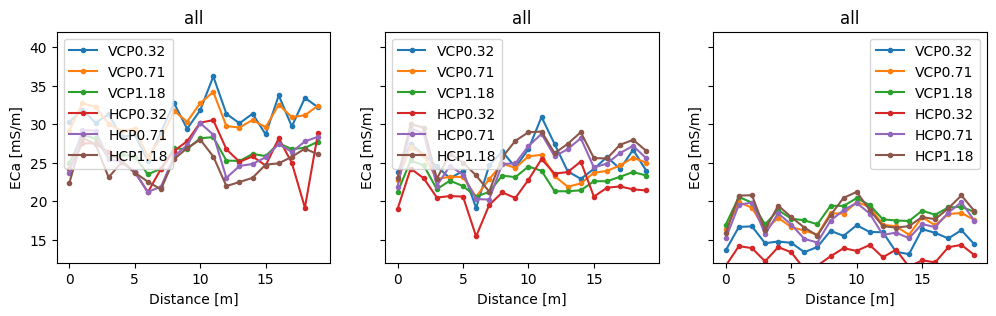

In [6]:
k = Problem()
k.createTimeLapseSurvey([datadir + 'timelapse-wheat/eca2017-03-16.csv',
                        datadir + 'timelapse-wheat/eca2017-04-27.csv',
                        datadir + 'timelapse-wheat/eca2017-05-16.csv'])
for s in k.surveys:
    s.df = s.df[:20]

# show apparent values collected
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))
for i in range(len(k.surveys)):
    ax = axs[i]
    k.show(index=i, ax=ax)
ax.set_ylim([12, 42])
k.setInit(depths0=[0.7], fixedDepths=[False])
bounds = [(0.1, 1),(2, 60),(2, 60)]


Survey 1/3
20/20 inverted
Survey 2/3
20/20 inverted
Survey 3/3
20/20 inverted

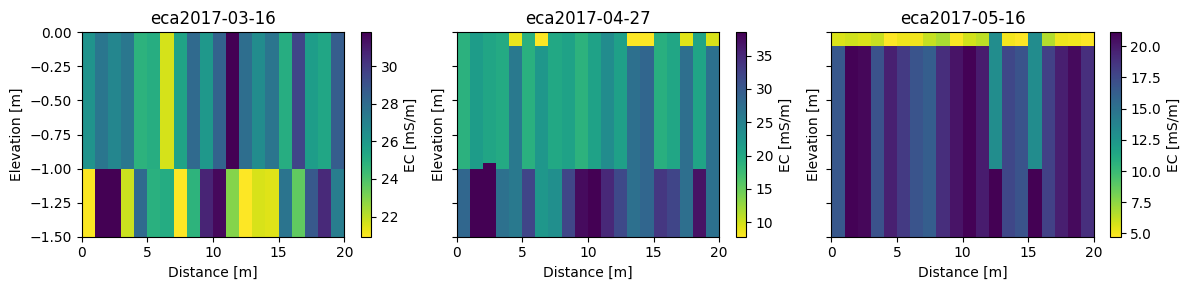

In [7]:
# inversion with gamma = 0 (no smoothing between surveys)
k.invert(gamma=0, bnds=bounds)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))
for i in range(3):
    ax = axs[i]
    k.showResults(index=i, ax=ax, maxDepth=1.5)


Survey 1/3
20/20 inverted
Survey 2/3
20/20 inverted
Survey 3/3
20/20 inverted

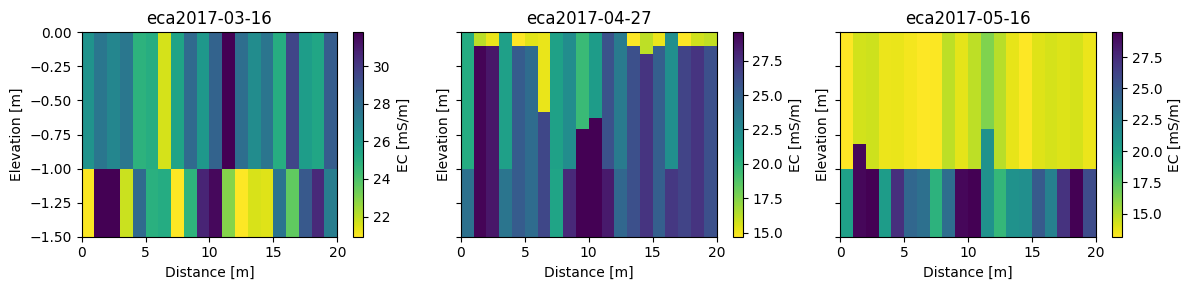

In [8]:
# inversion with constrain to the first survey
k.invert(gamma=0.1, bnds=bounds)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))
for i in range(3):
    ax = axs[i]
    k.showResults(index=i, ax=ax, maxDepth=1.5)

### Observations
In the second inversion with between survey constrain we can clearly see that the depths obtained during the first inversion constrain the depth of the other survey. We can also notice that the last two profiles are badly inverted in the first survey and so this propagate for the other subsequent surveys.

## Inverting change in ECa
An other way of producing time-lapse inversion is to actually invert for the change in ECa. This can be done using the CS function and the `Problem.invertGN()` function. See appendix of Whalley et al. (2017) for more details.

Trimming surveys and only keep common positions
Matching positions between surveys for time-lapse inversion...20 in common...done in 0.00401s
Computing relative ECa compared to background (1st survey).


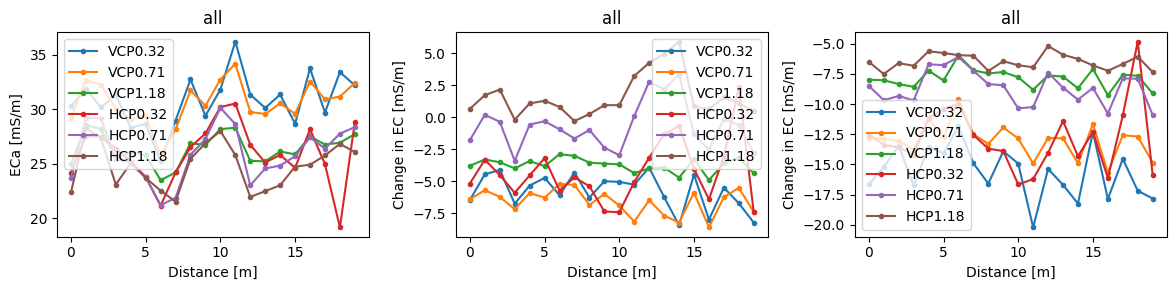

In [9]:
k = Problem()
k.createTimeLapseSurvey([datadir + 'timelapse-wheat/eca2017-03-16.csv',
                        datadir + 'timelapse-wheat/eca2017-04-27.csv',
                        datadir + 'timelapse-wheat/eca2017-05-16.csv'])
for s in k.surveys:
    s.df = s.df[:20]
    
k.computeApparentChange()
# show change in apparent values collected
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(12,3))
for i in range(len(k.surveys)):
    ax = axs[i]
    k.show(index=i, ax=ax)
    if i > 0:
        ax.set_ylabel('Change in EC [mS/m]')
fig.tight_layout()

Survey 1/3
20/20 inverted
Survey 2/3
20/20 inverted
Survey 3/3
20/20 inverted


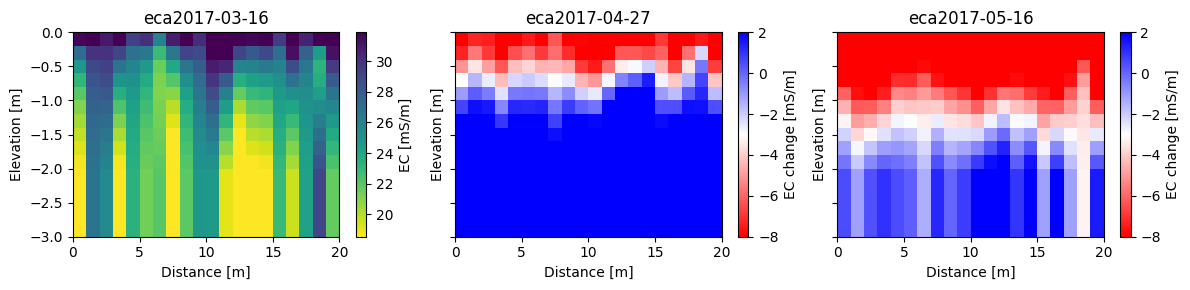

In [10]:
k.setInit(depths0=np.linspace(0.2, 2, 10)) # use a smooth model
k.invertGN(alpha=0.1)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3))
for i in range(3):
    ax = axs[i]
    if i == 0: # reference survey
        k.showResults(index=i, ax=ax)
    else:
        k.showResults(index=i, ax=ax, cmap='bwr_r', vmin=-8, vmax=2)
        fig.axes[-1].set_ylabel('EC change [mS/m]')